## Importing the Libraries

The first step is to import the libraries required to preprocess Mosaic24 stock data and the other libraries required for constructing and visualizing the LSTM model outputs. We’ll be using the Keras library from the TensorFlow framework for this. All modules are imported from the Keras library.

In [12]:
#Importing the Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils import plot_model

## Getting to Visualising the Stock Market Prediction Data

Using the Pandas Data Reader library, we will upload the stock data from the local system as a Comma Separated Value (.csv) file and save it to a pandas DataFrame. Finally, we will examine the data.

In [21]:
# Importing the data
df = pd.read_csv("data/train.csv",index_col="Date",parse_dates=True,infer_datetime_format=True)
df.head()

C:\Users\alaza\AppData\Local\Temp\ipykernel_14392\2734896154.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("data/train.csv",index_col="Date",parse_dates=True,infer_datetime_format=True)


,Id,Open,High,Low,Close,Adj Close,Volume,Company
Date,,,,,,,,
2033-03-01,0,159.271109,167.221488,157.380478,161.915062,160.167043,40490589,Company_0
2033-03-01,1,114.571843,114.409664,112.921505,113.066659,87.844722,8592865,Company_1
2033-03-01,2,50.984499,51.262529,50.266272,50.094499,49.329834,25085661,Company_2
2033-03-01,3,98.585428,99.988079,97.867719,98.811966,91.784469,823271,Company_3
2033-03-01,4,8874.646107,8935.704765,8811.247764,8873.173069,8407.389386,609369,Company_4


## Checking for Null Values

We’ll check for null values in the data frame to ensure that there are none. The existence of null values in the dataset causes issues during training since they function as outliers

In [22]:
# checking for null values
df.isna().sum()

Id           0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Company      0
dtype: int64

In [23]:
#  check for duplicated data
df.duplicated().sum()

0

##  Plotting the True Close Value

The Close Value is the final output value that will be forecasted using the Machine Learning model. This figure indicates the stock’s closing price on that particular day of stock market trading.

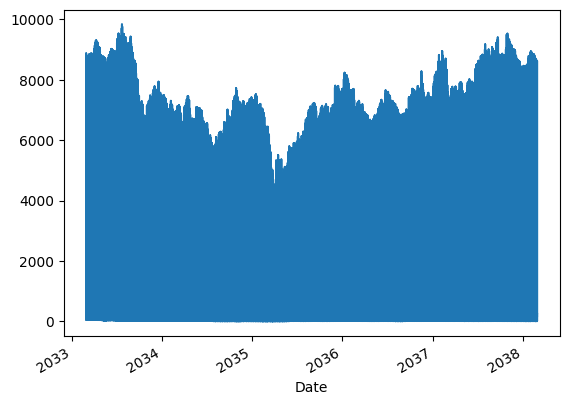

In [24]:
df["Close"].plot(kind="line");

## Setting the Target Variable and Selecting the Features

The output column is then assigned to the target variable.
Furthermore, we pick the features that serve as the independent variable to the target variable (dependent variable).